# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime

2023-02-17 11:39:46.363926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 11:39:48.834610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/include:/usr/local/cuda-11.8/lib64:
2023-02-17 11:39:48.834756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/include:/usr/local/cuda-11.8/lib64:
2023-02-17 11:39

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-02-17 11:39:51.285406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 11:39:52.661383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 750 Ti, pci bus id: 0000:02:00.0, compute capability: 5.0


# Data

In [3]:
DATA_PATH = "./data/"
BATCH_SIZE = 8
IMAGE_SIZE = (256, 256)
SEED = 123

def getDataset(path):
    return tf.keras.utils.image_dataset_from_directory(
                path,
                labels=None,
                color_mode='rgb',
                batch_size=BATCH_SIZE,
                image_size=IMAGE_SIZE,
                shuffle=True,
                seed=SEED,
                validation_split=None,
                interpolation='bilinear',
                crop_to_aspect_ratio=True,
            )

In [4]:
train_x = getDataset(DATA_PATH + "training/images")
train_y = getDataset(DATA_PATH + "training/instances")

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.


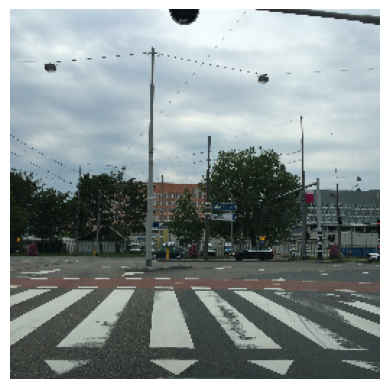

In [5]:
for batch in train_x.take(1):
    im = batch[0].numpy().astype("uint8")
    plt.imshow(im)
    plt.axis("off")

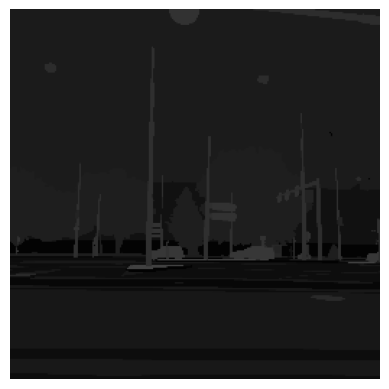

In [6]:
for batch in train_y.take(1):
    im = batch[0].numpy().astype("uint8")
    plt.imshow(im)
    plt.axis("off")

In [7]:
test_x = getDataset(DATA_PATH + "validation/images")
test_y = getDataset(DATA_PATH + "validation/instances")

Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


# Import pix2pix

In [8]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [10]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    pix2pix.upsample(64, 3),   # 64x64 -> 128x128
]

In [11]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 128x128 -> 256x256

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [22]:
train_ds = tf.data.Dataset.zip((train_x, train_y))

In [23]:
EPOCHS = 20
STEPS_PER_EPOCH = 800 // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 200//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data= [test_x, test_y],
                          callbacks=[DisplayCallback()])

Epoch 1/20


2023-02-17 12:13:49.718456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-17 12:13:51.276494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: cublas error
2023-02-17 12:13:51.280066: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1152 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cu

NotFoundError: Graph execution error:

Detected at node 'model_1/model/Conv1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7410/269819189.py", line 6, in <module>
      model_history = model.fit(train_ds, epochs=EPOCHS,
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/asus/Documents/instance-segmentation/venv/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/model/Conv1/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(4294): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node model_1/model/Conv1/Conv2D}}]] [Op:__inference_train_function_10390]